<a href="https://colab.research.google.com/github/amanzoni1/MoE-Burst-Upcycling/blob/main/HELLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Uninstall the conflicting library
!pip uninstall -y torchvision

# 2. Force install the bleeding-edge Transformers (fixes the missing OLMoE class)
!pip install -U git+https://github.com/huggingface/transformers

# 3. Install core dependencies
!pip install -U torch accelerate peft datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-2126y2x2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2126y2x2
  Resolved https://github.com/huggingface/transformers to commit c8561da82c42adca9325f01ce1ff5aabadea0c3f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
from transformers import OlmoeForCausalLM, AutoTokenizer

model_name = "allenai/OLMoE-1B-7B-0924"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = OlmoeForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/179 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [10]:
import torch
import os

# Global Configuration
CONFIG = {
    "batch_size": 32,
    "seq_len": 2048,
    "seed": 123,
    "output_dir": "./telemetry"
}

# Dataset Registry
DATASETS = {
    "gsm8k": {
        "path": "gsm8k",
        "name": "main",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"Question: {item['question']}\nAnswer: {item['answer']}"
    },
    "wikitext": {
        "path": "wikitext",
        "name": "wikitext-2-raw-v1",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: item['text']
    },
    "code_alpaca": {
        "path": "sahil2801/CodeAlpaca-20k",
        "name": None,
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"{item['instruction']}\n{item['input']}\n{item['output']}"
    }
}

In [4]:
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import os

class ProfilerEngine:
    def __init__(self, model, tokenizer, output_dir):
        self.model = model
        self.tokenizer = tokenizer
        self.output_dir = output_dir

        # Dynamic architecture detection
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            self.layers = model.model.layers
        elif hasattr(model, "layers"): # Fallback for some architectures
            self.layers = model.layers
        else:
            raise ValueError("Could not automatically identify model layers.")

        self.num_layers = len(self.layers)
        self.hooks = []
        self.data_buffer = {}

        # Create output dir if not exists
        os.makedirs(self.output_dir, exist_ok=True)

    def _get_hook(self, layer_idx):
        """Closure for capturing telemetry."""
        def hook(module, input, output):
            # Extract logits (support tuple output)
            logits = output[0] if isinstance(output, tuple) else output

            # Flatten [Batch, Seq, Experts] -> [Total_Tokens, Experts]
            logits = logits.view(-1, logits.shape[-1])

            # Top-K Indices
            _, indices = torch.topk(logits, k=8, dim=-1)

            # CPU Offload & Storage
            counts = torch.bincount(indices.flatten(), minlength=64).cpu()
            total_tokens = indices.numel()

            self.data_buffer[layer_idx]["counts"].append(counts)
            self.data_buffer[layer_idx]["total"].append(total_tokens)

        return hook

    def attach_hooks(self):
        """Registers hooks dynamically based on model depth."""
        self.hooks = []
        self.data_buffer = {i: {"counts": [], "total": []} for i in range(self.num_layers)}

        print(f"[System] Attaching probes to {self.num_layers} layers...")
        for i, layer in enumerate(self.layers):
            # Note: layer.mlp.gate is specific to OLMoE.
            # For other models (Mixtral/Qwen), this path may change (e.g., block_sparse_moe.gate).
            self.hooks.append(layer.mlp.gate.register_forward_hook(self._get_hook(i)))

    def detach_hooks(self):
        for h in self.hooks: h.remove()
        self.hooks = []
        print("[System] Hooks detached.")

    def run_dataset(self, dataset_key):
        """Executes profiling for a single dataset."""
        if dataset_key not in DATASETS:
            raise ValueError(f"Dataset '{dataset_key}' not found in registry.")

        cfg = DATASETS[dataset_key]
        print(f"\n[Profiler] Starting run: {dataset_key.upper()}")
        print(f"           Source: {cfg['path']} | Samples: {cfg['num_samples']}")

        # Load & Prep
        ds = load_dataset(cfg["path"], cfg.get("name"), split=cfg["split"])
        ds = ds.shuffle(seed=CONFIG["seed"]).select(range(cfg["num_samples"]))

        self.attach_hooks()

        batch_text = []
        pbar = tqdm(total=cfg["num_samples"], desc="Processing")

        for item in ds:
            text = cfg["text_fn"](item)
            if len(text) < 10: continue

            batch_text.append(text)

            if len(batch_text) == CONFIG["batch_size"]:
                self._process_batch(batch_text)
                pbar.update(len(batch_text))
                batch_text = []

        if batch_text:
            self._process_batch(batch_text)
            pbar.update(len(batch_text))

        pbar.close()
        self.detach_hooks()
        return self._save(dataset_key)

    def _process_batch(self, batch_text):
        inputs = self.tokenizer(
            batch_text, return_tensors="pt", padding=True, truncation=True,
            max_length=CONFIG["seq_len"]
        ).to(self.model.device)

        with torch.no_grad():
            self.model(**inputs)

    def _save(self, dataset_key):
        filename = os.path.join(self.output_dir, f"olmoe_activations_{dataset_key}.pt")

        final_data = {}
        for layer, data in self.data_buffer.items():
            final_data[layer] = {
                "counts": torch.stack(data["counts"]),
                "total": torch.tensor(data["total"])
            }

        torch.save(final_data, filename)
        print(f"[IO] Telemetry saved: {filename}")
        return filename

In [5]:
def run_profiling(targets):
    """
    Main entry point for profiling.
    Args:
        targets (list): List of dataset keys (e.g., ['gsm8k', 'wikitext'])
    """
    # Initialize Engine
    engine = ProfilerEngine(model, tokenizer, output_dir=CONFIG["output_dir"])

    generated_files = []

    for target in targets:
        try:
            path = engine.run_dataset(target)
            generated_files.append(path)
        except Exception as e:
            print(f"[Error] Failed to profile {target}: {str(e)}")

    return generated_files

In [6]:
output_files = run_profiling(targets=["gsm8k"])


[Profiler] Starting run: GSM8K
           Source: gsm8k | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_gsm8k.pt


In [11]:
output_files = run_profiling(targets=["wikitext", "code_alpaca"])


[Profiler] Starting run: WIKITEXT
           Source: wikitext | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_wikitext.pt

[Profiler] Starting run: CODE_ALPACA
           Source: sahil2801/CodeAlpaca-20k | Samples: 1000


README.md:   0%|          | 0.00/147 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_code_alpaca.pt


In [12]:
from google.colab import files

def download_results(file_paths):
    print(f"\n[System] Preparing {len(file_paths)} files for download...")
    for path in file_paths:
        try:
            files.download(path)
        except Exception as e:
            print(f"[Error] Could not download {path}: {e}")

# Trigger download of files generated in previous step
download_results(output_files)


[System] Preparing 2 files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ File loaded successfully! Size: 0.28 MB
   Layers detected: 16 (should be 16)
   Batches per layer: 32 (≈125 for 1000 samples / batch=8)
   Experts per layer: 64 (should be 64)

Layer 0 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 10.45%
   Top-8 experts share: 44.44% (>>12.5% uniform = good skew)
   Top-16 experts share: 63.82%

Layer 7 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 8.88%
   Top-8 experts share: 49.82% (>>12.5% uniform = good skew)
   Top-16 experts share: 68.21%

Layer 15 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 10.12%
   Top-8 experts share: 39.30% (>>12.5% uniform = good skew)
   Top-16 experts share: 58.19%



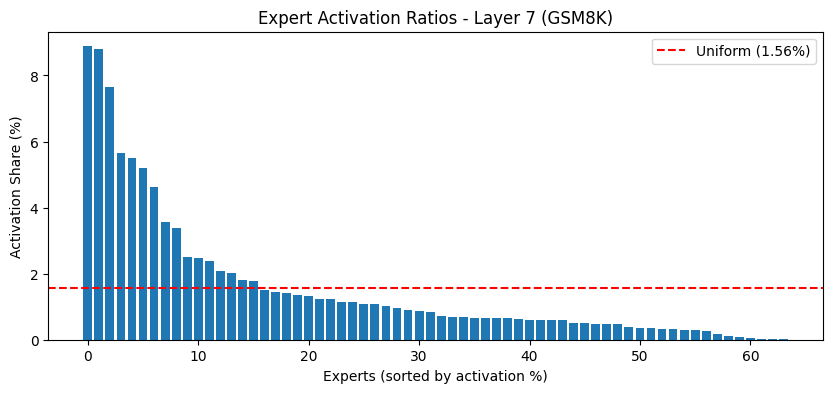

In [8]:
import torch
import matplotlib.pyplot as plt
import os

# Load the telemetry file
file_path = "./telemetry/olmoe_activations_gsm8k.pt"
if not os.path.exists(file_path):
    print("File not found—profiling likely failed.")
else:
    data = torch.load(file_path)
    print(f"✅ File loaded successfully! Size: {os.path.getsize(file_path)/1e6:.2f} MB")
    print(f"   Layers detected: {len(data)} (should be 16)")
    print(f"   Batches per layer: {data[0]['counts'].shape[0]} (≈125 for 1000 samples / batch=8)")
    print(f"   Experts per layer: {data[0]['counts'].shape[1]} (should be 64)\n")

    # Compute aggregate stats across all batches
    for layer_idx in [0, 7, 15]:  # Example: early/mid/late layers
        counts = data[layer_idx]["counts"].sum(dim=0).float()  # Total counts [64]
        total_activations = data[layer_idx]["total"].sum().item()  # Total top-8 selections
        ratios = (counts / total_activations) * 100  # % share per expert

        sorted_ratios, sorted_idx = torch.sort(ratios, descending=True)
        uniform_ratio = 100 / 64  # ~1.56%

        print(f"Layer {layer_idx} Summary:")
        print(f"   Total activations tracked: {total_activations:,}")
        print(f"   Uniform expected ratio: {uniform_ratio:.2f}%")
        print(f"   Top-1 expert share: {sorted_ratios[0]:.2f}%")
        print(f"   Top-8 experts share: {sorted_ratios[:8].sum():.2f}% (>>12.5% uniform = good skew)")
        print(f"   Top-16 experts share: {sorted_ratios[:16].sum():.2f}%\n")

    # Quick visual: Sorted bar plot for one layer (e.g., layer 7—adjust as needed)
    layer_to_plot = 7
    ratios = (data[layer_to_plot]["counts"].sum(0).float() / data[layer_to_plot]["total"].sum()) * 100
    sorted_ratios, _ = torch.sort(ratios, descending=True)

    plt.figure(figsize=(10, 4))
    plt.bar(range(64), sorted_ratios)
    plt.axhline(y=uniform_ratio, color='r', linestyle='--', label=f"Uniform ({uniform_ratio:.2f}%)")
    plt.title(f"Expert Activation Ratios - Layer {layer_to_plot} (GSM8K)")
    plt.xlabel("Experts (sorted by activation %)")
    plt.ylabel("Activation Share (%)")
    plt.legend()
    plt.show()

In [9]:
import torch
import os

# 1. Locate the file
file_path = "./telemetry/olmoe_activations_gsm8k.pt"

print(f"🔍 INSPECTING: {file_path}")

if not os.path.exists(file_path):
    print("❌ File not found! Did you run the profiler?")
else:
    # 2. Load the data
    data = torch.load(file_path)

    # 3. Check Structure
    print(f"✅ File loaded successfully.")
    print(f"   Layers captured: {len(data.keys())} (Should be 16)")

    # 4. Deep Dive into a Random Layer (e.g., Layer 8)
    layer_idx = 8
    layer_data = data[layer_idx]

    counts = layer_data["counts"]      # Shape: [Num_Batches, 64]
    total = layer_data["total"]        # Shape: [Num_Batches]

    print(f"\n📊 LAYER {layer_idx} STATS:")
    print(f"   - Batches processed: {counts.shape[0]}")
    print(f"   - Experts tracked:   {counts.shape[1]}")

    # 5. The "Pulse" Check (Are values non-zero?)
    total_acts = counts.sum().item()
    if total_acts == 0:
        print("⚠️ WARNING: This layer is empty (All zeros). Something is wrong.")
    else:
        print(f"   - Total Expert Activations: {total_acts:,}")

        # Who is the "Hot" expert in this layer?
        # Sum across all batches to get global counts
        global_counts = counts.sum(dim=0)
        top_expert_idx = torch.argmax(global_counts).item()
        top_expert_count = global_counts[top_expert_idx].item()
        usage_percent = (top_expert_count / total_acts) * 100

        print(f"   - 🔥 Hottest Expert: #{top_expert_idx} (Used {usage_percent:.2f}% of the time)")

        # Who is "Cold"?
        zeros = (global_counts == 0).sum().item()
        print(f"   - ❄️ Unused Experts: {zeros}")

print("\nVerdict: If you see 'Hottest Expert' numbers above, it worked perfectly.")

🔍 INSPECTING: ./telemetry/olmoe_activations_gsm8k.pt
✅ File loaded successfully.
   Layers captured: 16 (Should be 16)

📊 LAYER 8 STATS:
   - Batches processed: 32
   - Experts tracked:   64
   - Total Expert Activations: 2,421,696
   - 🔥 Hottest Expert: #45 (Used 8.66% of the time)
   - ❄️ Unused Experts: 0

Verdict: If you see 'Hottest Expert' numbers above, it worked perfectly.


In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os

# Set clearer plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
from google.colab import files

# Clean up previous uploads to avoid duplicates if you re-run
for f in glob.glob("*.pt"):
    os.remove(f)

print("📂 Please upload your .pt files (wikitext, gsm8k, code_alpaca)...")
uploaded = files.upload()

print(f"\n✅ Uploaded {len(uploaded)} files.")
for fn in uploaded.keys():
    print(f"   - {fn}")

📂 Please upload your .pt files (wikitext, gsm8k, code_alpaca)...


Saving olmoe_activations_code_alpaca.pt to olmoe_activations_code_alpaca.pt
Saving olmoe_activations_gsm8k.pt to olmoe_activations_gsm8k.pt
Saving olmoe_activations_wikitext.pt to olmoe_activations_wikitext.pt

✅ Uploaded 3 files.
   - olmoe_activations_code_alpaca.pt
   - olmoe_activations_gsm8k.pt
   - olmoe_activations_wikitext.pt


📊 Processing 3 datasets...

generating heatmaps...


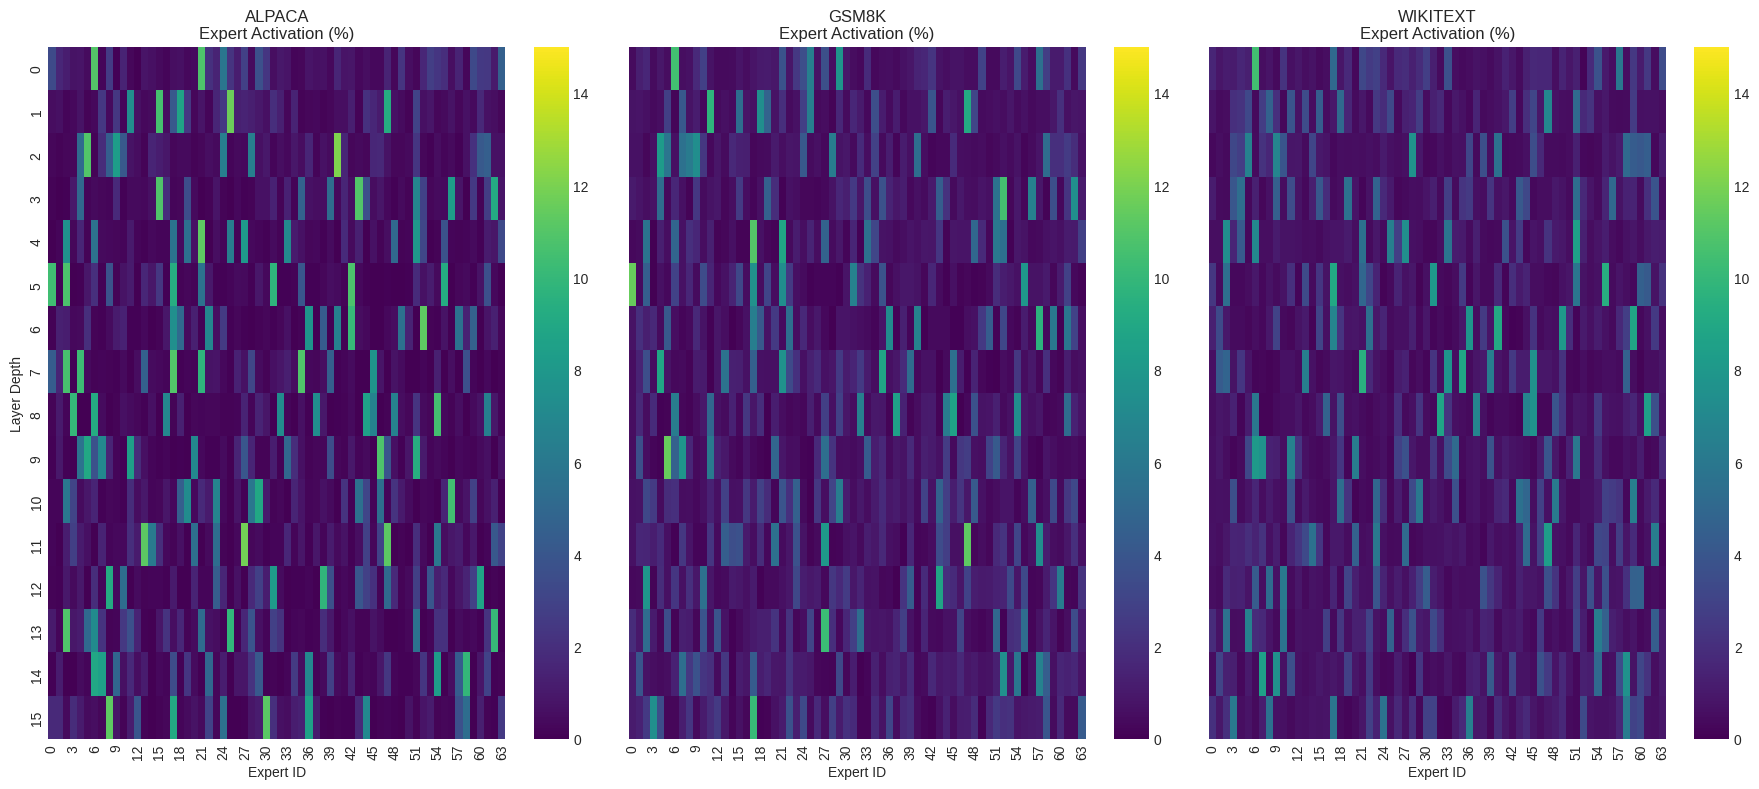

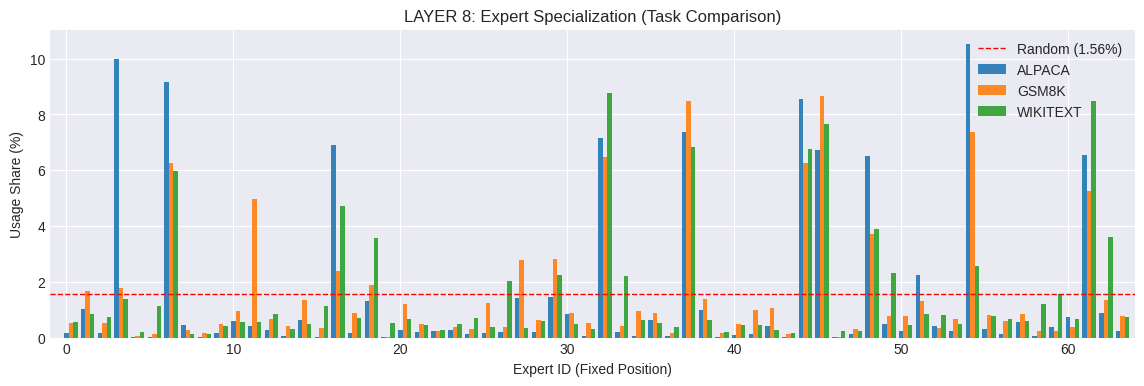

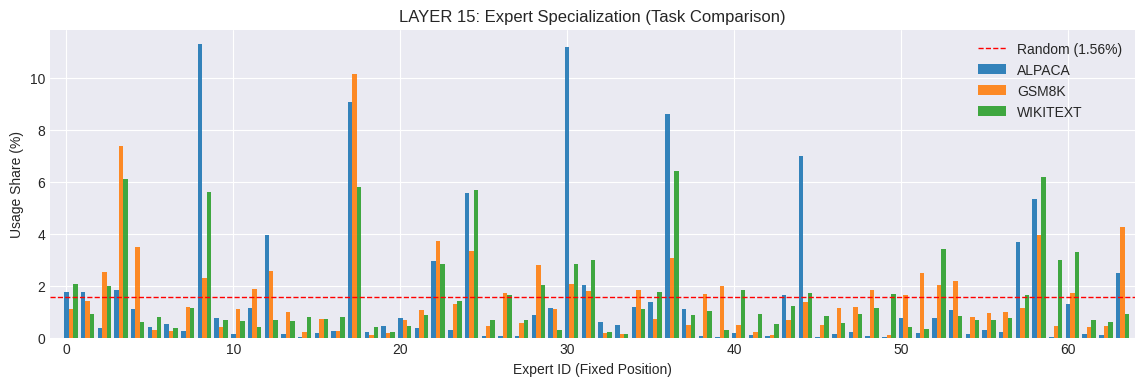


📈 STATS REPORT: ALPACA
Layer  | Top-1      | Top-8      | Experts for 90%    | Entropy   
----------------------------------------------------------------------
L00    |  11.0%      |  45.5%      | 37 experts        | 5.21
L01    |  11.6%      |  57.1%      | 34 experts        | 4.91
L02    |  12.1%      |  58.2%      | 31 experts        | 4.83
L03    |  10.9%      |  61.0%      | 26 experts        | 4.70
L04    |  11.3%      |  59.6%      | 22 experts        | 4.62
L05    |  10.7%      |  69.8%      | 19 experts        | 4.36
L06    |  11.3%      |  61.2%      | 21 experts        | 4.57
L07    |  10.9%      |  69.3%      | 21 experts        | 4.37
L08    |  10.5%      |  66.4%      | 19 experts        | 4.38
L09    |  10.8%      |  62.3%      | 22 experts        | 4.58
L10    |  10.5%      |  56.2%      | 27 experts        | 4.84
L11    |  11.8%      |  61.1%      | 25 experts        | 4.67
L12    |   9.8%      |  54.7%      | 25 experts        | 4.79
L13    |  10.9%      |  57.8%   

In [3]:
# ==========================================
# 1. LOAD & NORMALIZE DATA
# ==========================================
telemetry = {}
file_paths = glob.glob("*.pt")

if not file_paths:
    print("❌ No .pt files found! Did you run the upload cell?")
else:
    print(f"📊 Processing {len(file_paths)} datasets...")

    for path in file_paths:
        # Extract clean name (e.g., 'olmoe_activations_gsm8k.pt' -> 'gsm8k')
        name = path.split('_')[-1].replace('.pt', '')

        raw = torch.load(path)

        # Create empty matrix [16 Layers x 64 Experts]
        prob_matrix = torch.zeros((16, 64))

        for layer_idx, data in raw.items():
            # Sum counts across all batches
            total_counts = data["counts"].sum(dim=0).float()
            total_volume = data["total"].sum().float()

            # Normalize to percentage (0-100%)
            if total_volume > 0:
                prob_matrix[layer_idx] = (total_counts / total_volume) * 100

        telemetry[name] = prob_matrix

    # ==========================================
    # 2. VISUALIZATION: HEATMAPS (The "Fingerprints")
    # ==========================================
    datasets = sorted(list(telemetry.keys()))

    # Dynamic plot size based on number of datasets
    fig, axes = plt.subplots(1, len(datasets), figsize=(6 * len(datasets), 8), sharey=True)
    if len(datasets) == 1: axes = [axes] # Handle single case

    print("\ngenerating heatmaps...")
    for i, ds_name in enumerate(datasets):
        matrix = telemetry[ds_name].numpy()

        sns.heatmap(
            matrix,
            ax=axes[i],
            cmap="viridis",
            cbar=True,
            vmin=0, vmax=15 # Cap color at 15% to see contrast
        )
        axes[i].set_title(f"{ds_name.upper()}\nExpert Activation (%)")
        axes[i].set_xlabel("Expert ID")
        if i == 0: axes[i].set_ylabel("Layer Depth")

    plt.tight_layout()
    plt.show()

    # ==========================================
    # 3. VISUALIZATION: LAYER COMPARISON (Unsorted)
    # ==========================================
    # We look at Layer 8 (Mid-reasoning) and Layer 15 (Output)
    target_layers = [8, 15]

    for layer_idx in target_layers:
        plt.figure(figsize=(14, 4))

        x = np.arange(64)
        width = 0.8 / len(datasets)

        for i, ds_name in enumerate(datasets):
            usage = telemetry[ds_name][layer_idx].numpy()
            # Offset bars so they don't overlap
            plt.bar(x + (i * width), usage, width=width, label=ds_name.upper(), alpha=0.9)

        # Reference Line (Random Chance ~1.56%)
        plt.axhline(y=1.56, color='red', linestyle='--', linewidth=1, label="Random (1.56%)")

        plt.title(f"LAYER {layer_idx}: Expert Specialization (Task Comparison)")
        plt.xlabel("Expert ID (Fixed Position)")
        plt.ylabel("Usage Share (%)")
        plt.legend()
        plt.xlim(-1, 64)
        plt.show()

    # ==========================================
    # 4. STATS: EFFICIENCY & COVERAGE
    # ==========================================
    for ds_name in datasets:
        print(f"\n📈 STATS REPORT: {ds_name.upper()}")
        print(f"{'Layer':<6} | {'Top-1':<10} | {'Top-8':<10} | {'Experts for 90%':<18} | {'Entropy':<10}")
        print("-" * 70)

        matrix = telemetry[ds_name].numpy()

        for layer in range(16):
            probs = matrix[layer]
            sorted_probs = np.sort(probs)[::-1] # Descending

            top1 = sorted_probs[0]
            top8 = sorted_probs[:8].sum()

            # How many experts needed to cover 90% of traffic?
            cumsum = np.cumsum(sorted_probs)
            n_90 = np.searchsorted(cumsum, 90.0) + 1

            # Entropy (Spikiness)
            p_norm = probs / 100.0
            p_norm = p_norm[p_norm > 0]
            entropy = -np.sum(p_norm * np.log2(p_norm))

            print(f"L{layer:02d}    | {top1:5.1f}%      | {top8:5.1f}%      | {n_90:2d} experts        | {entropy:.2f}")

🔑 Available Dataset Keys: ['wikitext', 'alpaca', 'gsm8k']
🔄 Calculating Overlap for Layer 5...
   WIKITEXT   Top-8 Experts: {np.int64(2), np.int64(17), np.int64(51), np.int64(21), np.int64(55), np.int64(60), np.int64(61), np.int64(31)}
   GSM8K      Top-8 Experts: {np.int64(0), np.int64(2), np.int64(35), np.int64(10), np.int64(17), np.int64(21), np.int64(55), np.int64(31)}
   ALPACA     Top-8 Experts: {np.int64(0), np.int64(2), np.int64(35), np.int64(42), np.int64(17), np.int64(21), np.int64(55), np.int64(31)}


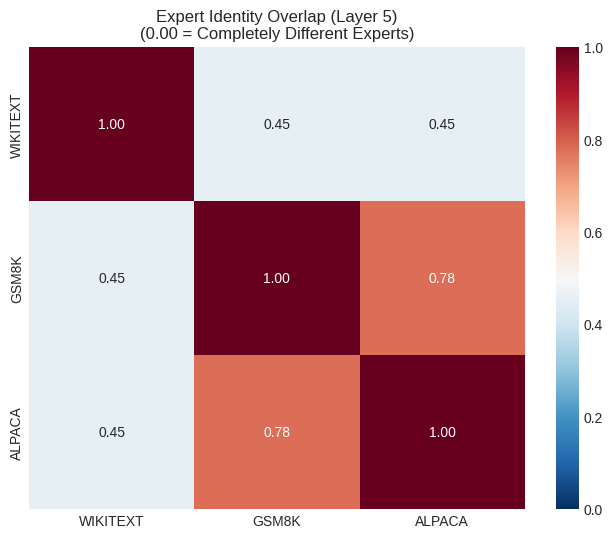

In [6]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Verify keys first (Debugging step)
print(f"🔑 Available Dataset Keys: {list(telemetry.keys())}")

# 2. Update the list to match the keys exactly
# 'alpaca' likely replaced 'code_alpaca' during the loading split
datasets = ["wikitext", "gsm8k", "alpaca"]
layer_to_check = 5

print(f"🔄 Calculating Overlap for Layer {layer_to_check}...")

# 3. Identify the "Hot Set" for each dataset
hot_sets = {}
for ds in datasets:
    if ds not in telemetry:
        print(f"⚠️ Warning: Key '{ds}' not found. Skipping.")
        continue

    # Get the global counts for this layer
    counts = telemetry[ds][layer_to_check].numpy()
    # Get indices of top 8
    top_8_indices = set(np.argsort(counts)[::-1][:8])
    hot_sets[ds] = top_8_indices
    # Use formatted print for cleaner output
    print(f"   {ds.upper():<10} Top-8 Experts: {top_8_indices}")

# 4. Build Jaccard Matrix
valid_datasets = [d for d in datasets if d in telemetry]
n = len(valid_datasets)
overlap_matrix = np.zeros((n, n))

for i, ds1 in enumerate(valid_datasets):
    for j, ds2 in enumerate(valid_datasets):
        set1 = hot_sets[ds1]
        set2 = hot_sets[ds2]

        # Jaccard = (Intersection) / (Union)
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))

        jaccard = intersection / union if union > 0 else 0
        overlap_matrix[i, j] = jaccard

# 5. Plot
if n > 0:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        overlap_matrix,
        annot=True,
        fmt=".2f",
        xticklabels=[d.upper() for d in valid_datasets],
        yticklabels=[d.upper() for d in valid_datasets],
        cmap="RdBu_r",
        vmin=0, vmax=1
    )
    plt.title(f"Expert Identity Overlap (Layer {layer_to_check})\n(0.00 = Completely Different Experts)")
    plt.show()

In [7]:
import torch
import pandas as pd
import numpy as np

# Settings
coverage_thresholds = [50, 80, 90, 95] # Dynamic thresholds
top_k_check = [2, 4, 8, 16]            # Static thresholds

results = []

print("DATA ANALYSIS: Layer-by-Layer Sparsity Check")
print("="*60)

for layer_idx in range(16):
    for ds_name in datasets: # ["wikitext", "gsm8k", "alpaca"]
        if ds_name not in telemetry: continue

        # Get data
        probs = telemetry[ds_name][layer_idx].numpy()
        sorted_probs = np.sort(probs)[::-1] # Descending order
        cumsum = np.cumsum(sorted_probs)

        # 1. Dynamic Coverage (How many experts to reach X%?)
        n_experts = {}
        for t in coverage_thresholds:
            # searchsorted returns index, so +1 gives count
            count = np.searchsorted(cumsum, t) + 1
            n_experts[f"Exp_for_{t}%"] = count

        # 2. Static Top-K (What % do they cover?)
        k_coverage = {}
        for k in top_k_check:
            cov = sorted_probs[:k].sum()
            k_coverage[f"Top{k}_Share"] = round(cov, 1)

        # 3. Entropy (Sparsity Metric)
        p_norm = probs[probs > 0] / 100.0
        entropy = -np.sum(p_norm * np.log2(p_norm))

        # Collect Row
        row = {
            "Layer": layer_idx,
            "Dataset": ds_name,
            "Entropy": round(entropy, 2),
            **n_experts, # Unpack dynamic counts
            **k_coverage # Unpack static shares
        }
        results.append(row)

# Create DataFrame
df = pd.DataFrame(results)

# --- ANALYSIS 1: The "Code vs Math" Gap ---
# We want to see WHICH layers are most different
print("\n🔎 SPARSITY GAP (Experts needed for 90% Coverage)")
print(f"{'Layer':<5} | {'Math':<5} | {'Code':<5} | {'Gap (Math - Code)':<15}")
print("-" * 45)

math_df = df[df["Dataset"] == "gsm8k"].set_index("Layer")
code_df = df[df["Dataset"] == "alpaca"].set_index("Layer")

for l in range(16):
    m = math_df.loc[l, "Exp_for_90%"]
    c = code_df.loc[l, "Exp_for_90%"]
    gap = m - c

    # Highlight big differences
    marker = "🔥🔥" if gap > 10 else ""
    print(f"L{l:02d}   | {m:<5} | {c:<5} | {gap:<5} {marker}")

# --- ANALYSIS 2: Full Data Export ---
# Save detailed report to check later
df.to_csv("olmoe_layer_sparsity_report.csv", index=False)
print("\n✅ Full report saved to 'olmoe_layer_sparsity_report.csv'")

DATA ANALYSIS: Layer-by-Layer Sparsity Check

🔎 SPARSITY GAP (Experts needed for 90% Coverage)
Layer | Math  | Code  | Gap (Math - Code)
---------------------------------------------
L00   | 43    | 37    | 6     
L01   | 41    | 34    | 7     
L02   | 39    | 31    | 8     
L03   | 38    | 26    | 12    🔥🔥
L04   | 36    | 22    | 14    🔥🔥
L05   | 34    | 19    | 15    🔥🔥
L06   | 32    | 21    | 11    🔥🔥
L07   | 37    | 21    | 16    🔥🔥
L08   | 35    | 19    | 16    🔥🔥
L09   | 36    | 22    | 14    🔥🔥
L10   | 41    | 27    | 14    🔥🔥
L11   | 37    | 25    | 12    🔥🔥
L12   | 39    | 25    | 14    🔥🔥
L13   | 38    | 25    | 13    🔥🔥
L14   | 42    | 24    | 18    🔥🔥
L15   | 39    | 25    | 14    🔥🔥

✅ Full report saved to 'olmoe_layer_sparsity_report.csv'


In [8]:
import torch
import json
import numpy as np

# Settings
TARGET_COVERAGE = 60.0  # Try 60% mass (usually captures the "Core" experts)
STATIC_K = 8            # Baseline

configs = {}

print(f"⚙️ GENERATING ADAPTIVE CONFIGS (Target: {TARGET_COVERAGE}% Coverage)")
print("="*60)
print(f"{'Layer':<5} | {'Math (Count)':<12} | {'Code (Count)':<12} | {'Savings (Code)'}")
print("-" * 60)

# We will build two lists: one for Math, one for Code
math_experts_map = {}
code_experts_map = {}

total_math_experts = 0
total_code_experts = 0

for layer_idx in range(16):
    # 1. Math Analysis
    probs_m = telemetry['gsm8k'][layer_idx].numpy()
    # Get indices that sort the array
    sorted_idx_m = np.argsort(probs_m)[::-1]
    sorted_val_m = probs_m[sorted_idx_m]

    # Cumulative Sum to find cut-off
    cumsum_m = np.cumsum(sorted_val_m)
    cutoff_m = np.searchsorted(cumsum_m, TARGET_COVERAGE) + 1
    # Keep at least 2 experts to be safe
    cutoff_m = max(2, cutoff_m)

    selected_m = sorted_idx_m[:cutoff_m].tolist()
    math_experts_map[str(layer_idx)] = selected_m
    total_math_experts += len(selected_m)

    # 2. Code Analysis
    probs_c = telemetry['alpaca'][layer_idx].numpy()
    sorted_idx_c = np.argsort(probs_c)[::-1]
    sorted_val_c = probs_c[sorted_idx_c]

    cumsum_c = np.cumsum(sorted_val_c)
    cutoff_c = np.searchsorted(cumsum_c, TARGET_COVERAGE) + 1
    cutoff_c = max(2, cutoff_c)

    selected_c = sorted_idx_c[:cutoff_c].tolist()
    code_experts_map[str(layer_idx)] = selected_c
    total_code_experts += len(selected_c)

    # Print comparison
    savings = total_math_experts - total_code_experts if layer_idx == 0 else (len(selected_m) - len(selected_c))
    print(f"L{layer_idx:02d}   | {len(selected_m):<12} | {len(selected_c):<12} | -{len(selected_m) - len(selected_c)}")

print("="*60)
print(f"TOTAL EXPERTS TRAINED (Target {TARGET_COVERAGE}%):")
print(f"  Math: {total_math_experts} (Avg {total_math_experts/16:.1f}/layer)")
print(f"  Code: {total_code_experts} (Avg {total_code_experts/16:.1f}/layer)")
print(f"  Baseline (Top-8): {8*16}")

# Save to JSON
final_configs = {
    "math_config": math_experts_map,
    "code_config": code_experts_map
}

with open("hellora_adaptive_config.json", "w") as f:
    json.dump(final_configs, f, indent=4)

print("\n✅ Config saved to 'hellora_adaptive_config.json'")

⚙️ GENERATING ADAPTIVE CONFIGS (Target: 60.0% Coverage)
Layer | Math (Count) | Code (Count) | Savings (Code)
------------------------------------------------------------
L00   | 15           | 14           | -1
L01   | 11           | 10           | -1
L02   | 12           | 9            | -3
L03   | 12           | 8            | -4
L04   | 10           | 9            | -1
L05   | 11           | 6            | -5
L06   | 11           | 8            | -3
L07   | 12           | 6            | -6
L08   | 10           | 8            | -2
L09   | 12           | 8            | -4
L10   | 18           | 9            | -9
L11   | 13           | 8            | -5
L12   | 16           | 10           | -6
L13   | 15           | 9            | -6
L14   | 17           | 9            | -8
L15   | 17           | 8            | -9
TOTAL EXPERTS TRAINED (Target 60.0%):
  Math: 212 (Avg 13.2/layer)
  Code: 139 (Avg 8.7/layer)
  Baseline (Top-8): 128

✅ Config saved to 'hellora_adaptive_config.json'


📊 PARETO ANALYSIS: Cost vs. Coverage

Analyzing GSM8K...
Layer  | 20% Cov  | 40% Cov  | 60% Cov  | 80% Cov  | 95% Cov 
---------------------------------------------------------------------------
L00    | 3  exp    | 7  exp    | 15 exp    | 30 exp    | 52 exp
L01    | 3  exp    | 6  exp    | 11 exp    | 26 exp    | 50 exp
L02    | 3  exp    | 7  exp    | 12 exp    | 24 exp    | 49 exp
L03    | 3  exp    | 7  exp    | 12 exp    | 25 exp    | 47 exp
L04    | 3  exp    | 6  exp    | 10 exp    | 23 exp    | 45 exp
L05    | 3  exp    | 5  exp    | 11 exp    | 21 exp    | 43 exp
L06    | 3  exp    | 6  exp    | 11 exp    | 20 exp    | 42 exp
L07    | 3  exp    | 6  exp    | 12 exp    | 25 exp    | 46 exp
L08    | 3  exp    | 6  exp    | 10 exp    | 23 exp    | 44 exp
L09    | 3  exp    | 6  exp    | 12 exp    | 23 exp    | 46 exp
L10    | 4  exp    | 10 exp    | 18 exp    | 30 exp    | 50 exp
L11    | 3  exp    | 6  exp    | 13 exp    | 25 exp    | 46 exp
L12    | 3  exp    | 8  exp    | 16 e

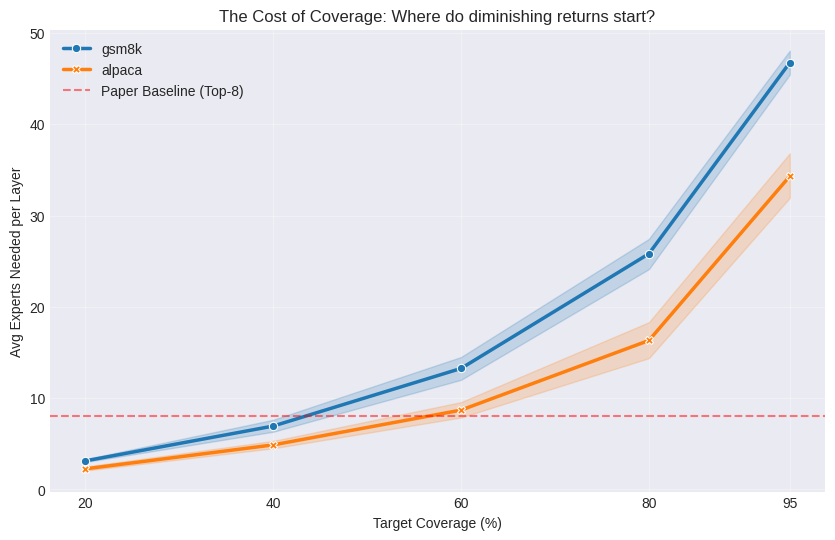

In [9]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the spectrum of ambition
thresholds = [20, 40, 60, 80, 95]

print("📊 PARETO ANALYSIS: Cost vs. Coverage")
print("="*60)

results = []

for ds_name in ["gsm8k", "alpaca"]:
    if ds_name not in telemetry: continue

    print(f"\nAnalyzing {ds_name.upper()}...")
    print(f"{'Layer':<6} | {'20% Cov':<8} | {'40% Cov':<8} | {'60% Cov':<8} | {'80% Cov':<8} | {'95% Cov':<8}")
    print("-" * 75)

    for layer in range(16):
        probs = telemetry[ds_name][layer].numpy()
        sorted_probs = np.sort(probs)[::-1] # Descending
        cumsum = np.cumsum(sorted_probs)

        # Calculate K needed for each threshold
        counts = []
        for t in thresholds:
            k = np.searchsorted(cumsum, t) + 1
            counts.append(k)

            # Save for plotting
            results.append({
                "Dataset": ds_name,
                "Layer": layer,
                "Target_Coverage": t,
                "Experts_Needed": k
            })

        # Print Row
        row_str = f"L{layer:02d}    | {counts[0]:<2} exp    | {counts[1]:<2} exp    | {counts[2]:<2} exp    | {counts[3]:<2} exp    | {counts[4]:<2} exp"
        print(row_str)

# ==========================================
# VISUALIZATION: The "Cost Curve"
# ==========================================
df = pd.DataFrame(results)

# We want to see the "Diminishing Returns"
# Plot Average Experts Needed vs Coverage
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df,
    x="Target_Coverage",
    y="Experts_Needed",
    hue="Dataset",
    style="Dataset",
    markers=True,
    dashes=False,
    linewidth=2.5
)

# Draw the "Baseline" (Top-8)
plt.axhline(y=8, color='red', linestyle='--', alpha=0.5, label="Paper Baseline (Top-8)")

plt.title("The Cost of Coverage: Where do diminishing returns start?")
plt.xlabel("Target Coverage (%)")
plt.ylabel("Avg Experts Needed per Layer")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(thresholds)
plt.show()

In [4]:
import torch
import numpy as np

# Define the "Coverage Sweep"
sweep_thresholds = [30, 40, 50, 60, 70]

# 1. DEBUG: Check what is actually inside
print(f"🔑 DEBUG: Found keys in telemetry: {list(telemetry.keys())}")

print("\n🔮 COVERAGE STRATEGY SIMULATION")
print("="*80)
print(f"{'Dataset':<12} | {'Cov%':<4} | {'Total Exp':<10} | {'Avg K':<6} | {'Min K':<6} | {'Max K':<6} | {'vs Baseline'}")
print("-" * 80)

# 2. Dynamic Loop: Iterate through WHATEVER is loaded
for ds_name in telemetry.keys():

    for target in sweep_thresholds:
        layer_ks = []

        for layer in range(16):
            probs = telemetry[ds_name][layer].numpy()
            sorted_val = np.sort(probs)[::-1]
            cumsum = np.cumsum(sorted_val)

            # Find K needed to hit target
            k = np.searchsorted(cumsum, target) + 1
            k = max(2, k) # Safety floor
            layer_ks.append(k)

        total_k = sum(layer_ks)
        avg_k = total_k / 16
        min_k = min(layer_ks)
        max_k = max(layer_ks)

        # Baseline Comparison
        diff = total_k - 128
        diff_str = f"{diff:+d}" if diff != 0 else "SAME"

        # Highlight the "Sweet Spot" (close to 128)
        marker = "👈" if abs(diff) < 5 else ""

        print(f"{ds_name:<12} | {target}%  | {total_k:<10} | {avg_k:<6.1f} | {min_k:<6} | {max_k:<6} | {diff_str:<10} {marker}")

    print("-" * 80)

🔑 DEBUG: Found keys in telemetry: ['wikitext', 'alpaca', 'gsm8k']

🔮 COVERAGE STRATEGY SIMULATION
Dataset      | Cov% | Total Exp  | Avg K  | Min K  | Max K  | vs Baseline
--------------------------------------------------------------------------------
wikitext     | 30%  | 82         | 5.1    | 4      | 7      | -46        
wikitext     | 40%  | 117        | 7.3    | 5      | 10     | -11        
wikitext     | 50%  | 160        | 10.0   | 7      | 13     | +32        
wikitext     | 60%  | 216        | 13.5   | 9      | 19     | +88        
wikitext     | 70%  | 301        | 18.8   | 14     | 25     | +173       
--------------------------------------------------------------------------------
alpaca       | 30%  | 56         | 3.5    | 3      | 4      | -72        
alpaca       | 40%  | 78         | 4.9    | 4      | 7      | -50        
alpaca       | 50%  | 105        | 6.6    | 5      | 10     | -23        
alpaca       | 60%  | 139        | 8.7    | 6      | 14     | +11        


In [5]:
import numpy as np
import json

thresholds = [30, 40, 45, 50, 60]  # Focus promising range

print("DYNAMIC COVERAGE CONFIG GENERATOR")
print("="*70)
print(f"{'Dataset':<12} | {'Threshold':<10} | {'Total Experts':<14} | {'Avg per Layer':<14} | {'% vs Fixed-8'}")
print("-"*70)

configs = {}  # For saving

for ds_name in telemetry.keys():
    configs[ds_name] = {}
    for thresh in thresholds:
        hot_map = {}
        layer_ks = []
        for layer in range(16):
            probs = telemetry[ds_name][layer].numpy()
            sorted_idx = np.argsort(probs)[::-1]
            cumsum = np.cumsum(probs[sorted_idx])
            k = np.searchsorted(cumsum, thresh) + 1
            k = max(2, k)
            layer_ks.append(k)
            hot_map[layer] = sorted_idx[:k].tolist()

        total = sum(layer_ks)
        avg = total / 16
        pct_vs_8 = (total - 128) / 128 * 100

        print(f"{ds_name:<12} | {thresh}%       | {total:<14} | {avg:<14.1f} | {pct_vs_8:+.1f}%")

        configs[ds_name][f"cov_{thresh}pct"] = hot_map

    print("-"*70)

# Save all (easy fine-tune switch)
with open("dynamic_hot_configs.json", "w") as f:
    json.dump(configs, f, indent=4)

print("Configs saved → use in get_target_modules() for LoraConfig")

DYNAMIC COVERAGE CONFIG GENERATOR
Dataset      | Threshold  | Total Experts  | Avg per Layer  | % vs Fixed-8
----------------------------------------------------------------------
wikitext     | 30%       | 82             | 5.1            | -35.9%
wikitext     | 40%       | 117            | 7.3            | -8.6%
wikitext     | 45%       | 139            | 8.7            | +8.6%
wikitext     | 50%       | 160            | 10.0           | +25.0%
wikitext     | 60%       | 216            | 13.5           | +68.8%
----------------------------------------------------------------------
alpaca       | 30%       | 56             | 3.5            | -56.2%
alpaca       | 40%       | 78             | 4.9            | -39.1%
alpaca       | 45%       | 91             | 5.7            | -28.9%
alpaca       | 50%       | 105            | 6.6            | -18.0%
alpaca       | 60%       | 139            | 8.7            | +8.6%
----------------------------------------------------------------------
g